# Introduction

This example demonstraites how to convert Caffe pretrained ResNet-50 model from https://github.com/KaimingHe/deep-residual-networks (firstly described in http://arxiv.org/pdf/1512.03385v1.pdf) into Theano/Lasagne format.

We will create a set of Lasagne layers corresponding to the Caffe model specification (prototxt), then copy the parameters from the caffemodel file into our model (like <a href="https://github.com/Lasagne/Recipes/blob/master/examples/Using%20a%20Caffe%20Pretrained%20Network%20-%20CIFAR10.ipynb">here</a>).

This notebook produce *resnet50.pkl* file, which contains dictionary with following foelds:
 * values: numpy array with parameters of the model
 * synset_words: labels of classes
 * mean_image: mean image which should be subtracted from each input image

This file can be used for initialization of weights of the model created by *modelzoo/resnet50.py*.

## License
Same as in parent project https://github.com/KaimingHe/deep-residual-networks/blob/master/LICENSE

# Requirements

## Download the required files

<a href="https://onedrive.live.com/?authkey=%21AAFW2-FVoxeVRck&id=4006CBB8476FF777%2117887&cid=4006CBB8476FF777">Here</a> you can find folder with caffe/proto files, we need followings to be stored in ./:
 * *ResNet-50-deploy.prototxt* contains architecture of ResNet-50 in proto format
 * *ResNet-50-model.caffemodel* is proto serialization of model parameters
 * *ResNet_mean.binaryproto* contains mean values
 
## Imports
We need caffe to load weights and compare results

In [1]:
import caffe

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We need a lot of building blocks from Lasagne to build network

In [2]:
import lasagne
from lasagne.utils import floatX
from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as ConvLayer # can be replaced with dnn layers
from lasagne.layers import BatchNormLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import DenseLayer
from lasagne.nonlinearities import rectify, softmax

Helper modules, some of them will help us to download images and plot them

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6
import io
import urllib
import skimage.transform
from IPython.display import Image
import pickle

# Build Lasagne model

## BatchNormalization issue in caffe

Caffe doesn't have correct BN layer as described in https://arxiv.org/pdf/1502.03167.pdf:
 * it can collect datasets mean ($\hat{\mu}$) and variance ($\hat{\sigma}^2$)
 * it can't fit $\gamma$ and $\beta$ parameters to scale and shift standardized distribution of feature in following formula: $\hat{x}_i = \dfrac{x_i - \hat{\mu}_i}{\sqrt{\hat{\sigma}_i^2 + \epsilon}}\cdot\gamma + \beta$

To fix this issue, <a href="https://github.com/KaimingHe/deep-residual-networks">here</a> authors use such BN layer followed by Scale layer, which can fit scale and shift parameters, but can't standardize data:

<pre>
layer {
	bottom: "res2a_branch1"
	top: "res2a_branch1"
	name: "bn2a_branch1"
	type: "BatchNorm"
	batch_norm_param {
		use_global_stats: true
	}
}

layer {
	bottom: "res2a_branch1"
	top: "res2a_branch1"
	name: "scale2a_branch1"
	type: "Scale"
	scale_param {
		bias_term: true
	}
}
</pre>

In Lasagne we have correct BN layer, so we do not need use such a trick.

## Replicated blocks

### Simple blocks

ResNet contains a lot of similar replicated blocks, lets call them *simple blocks*, which have one of two architectures:
 * Convolution $\rightarrow$ BN $\rightarrow$ Nonlinearity
 * Convolution $\rightarrow$ BN
 
http://ethereon.github.io/netscope/#/gist/2f702ea9e05900300462102a33caff9c

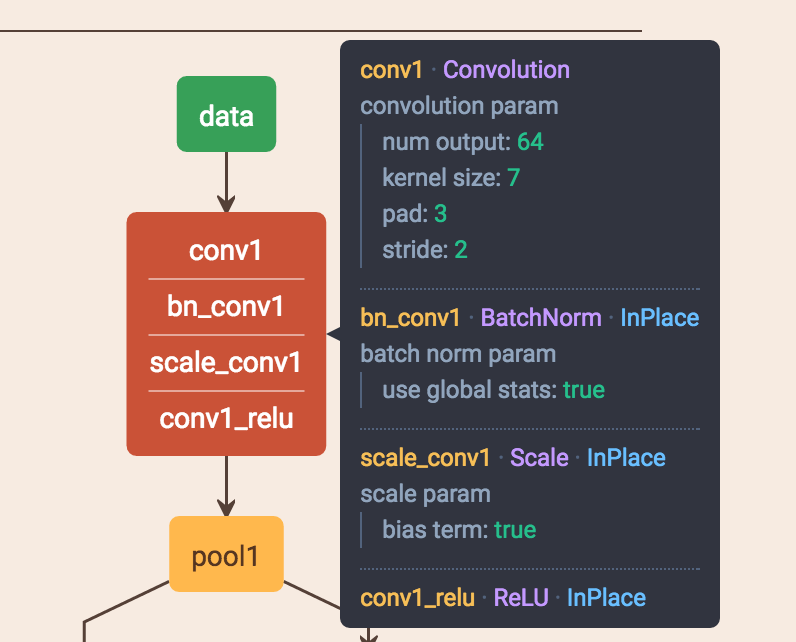

In [4]:
Image(filename='images/head.png', width='40%')

We can increase, decrease or keep same dimensionality of data using such blocks. In ResNet-50 only several transformation are used.

#### Keep shape with 1x1 convolution
We can apply nonlinearity transformation from (None, 64, 56, 56) to (None, 64, 56, 56) if we apply simple block with following parameters (look at the origin of a network after first pool layer):
 * num_filters: same as parent has
 * filter_size: 1
 * stride: 1
 * pad: 0

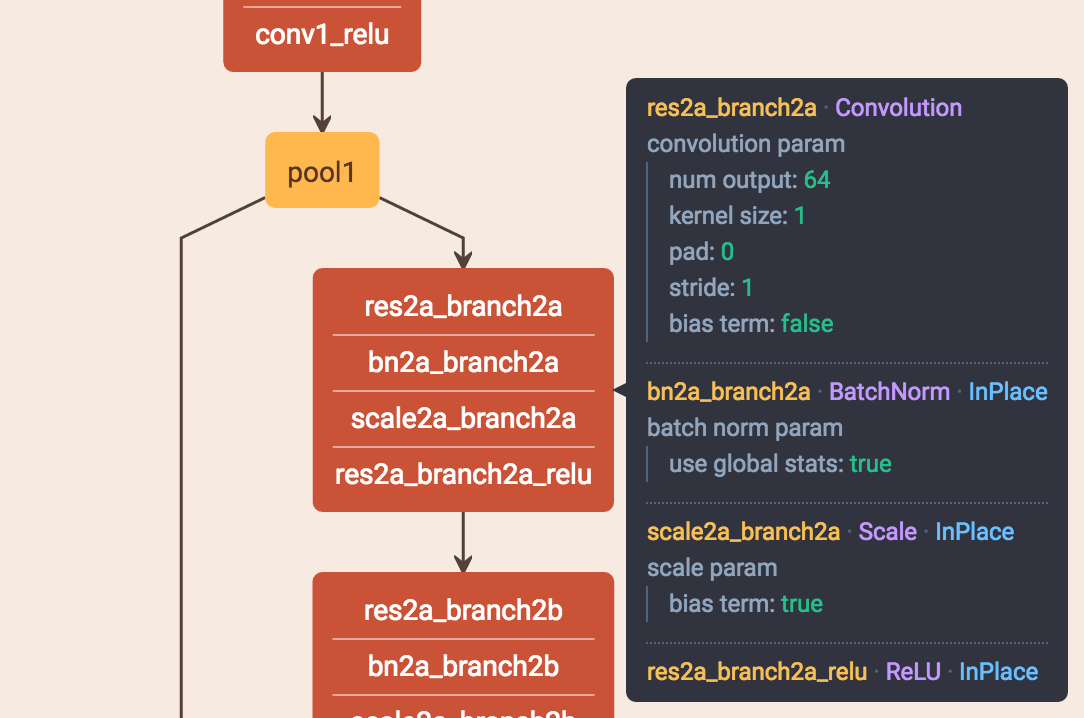

In [5]:
Image(filename='images/conv1x1.png', width='40%')

#### Keep shape with 3x3 convolution
Also we can apply nonlinearity transformation from (None, 64, 56, 56) to (None, 64, 56, 56) if we apply simple block with following parameters (look at the middle of any residual blocks):
 * num_filters: same as parent has
 * filter_size: 3x3
 * stride: 1
 * pad: 1

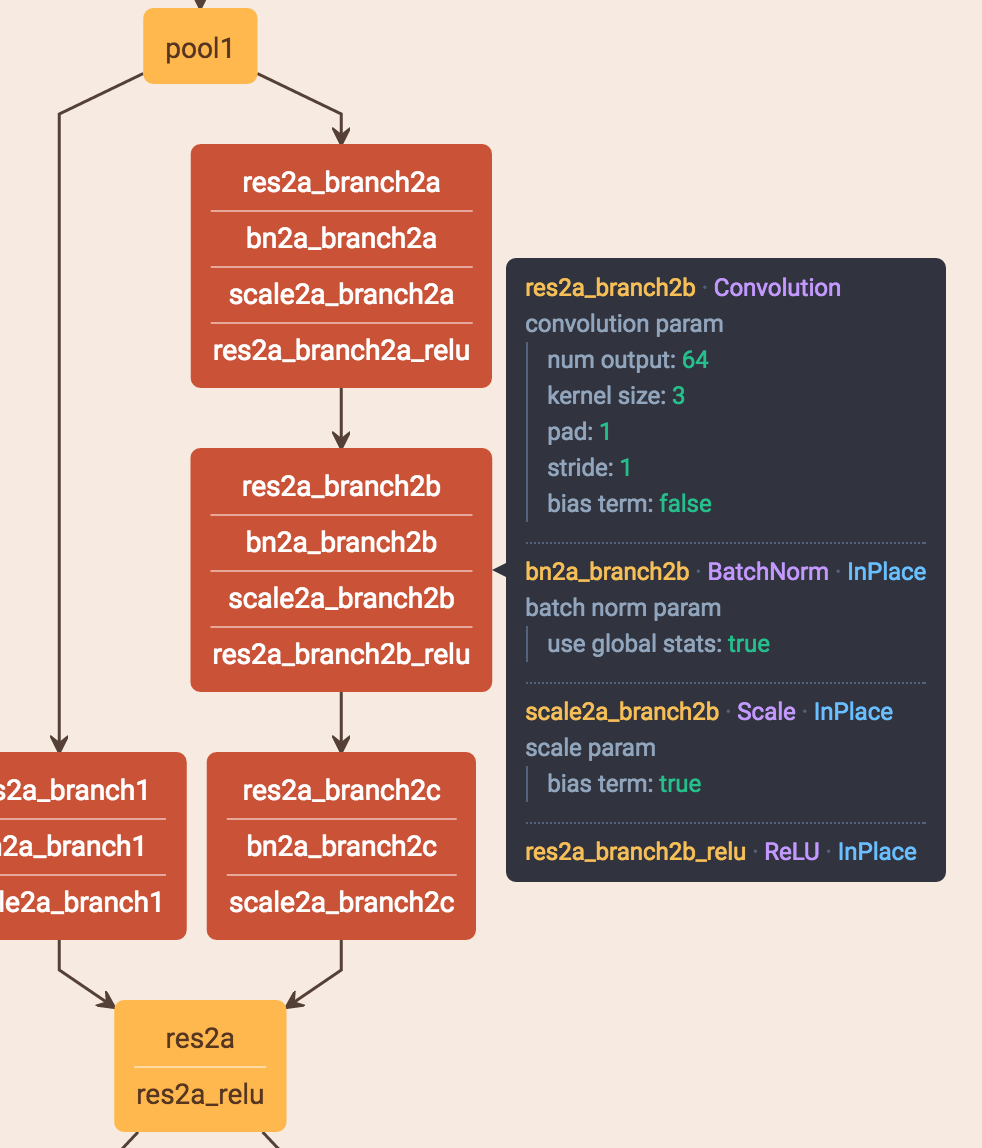

In [6]:
Image(filename='images/conv3x3.png', width='40%')

#### Increase shape using number of filters
We can nonlinearly increase shape from (None, 64, 56, 56) to (None, 256, 56, 56) if we apply simple block with following parameters (look at the last simple block of any risidual block):
 * num_filters: four times greater then parent has
 * filter_size: 1x1
 * stride: 1
 * pad: 0

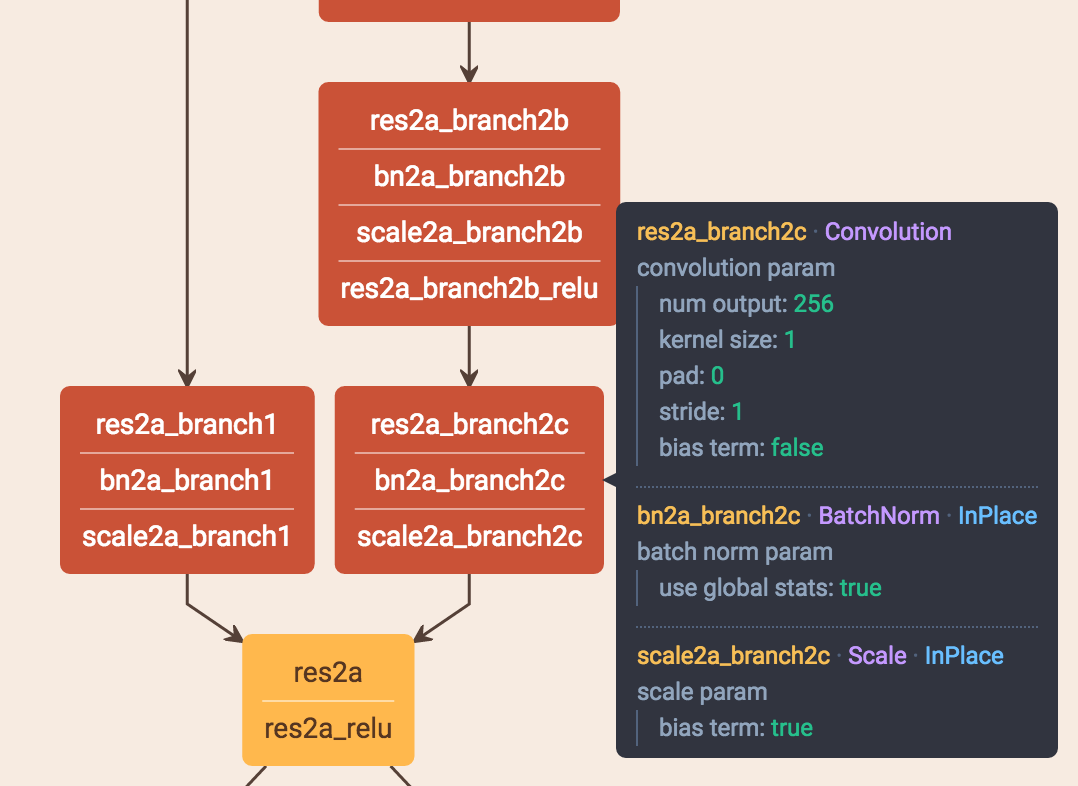

In [7]:
Image(filename='images/increase_fn.png', width='40%')

#### Increase shape using number of filters
We can nonlinearly decrease shape from (None, 256, 56, 56) to (None, 64, 56, 56) if we apply simple block with following parameters (look at the first simple block of any risidual block without left branch):
 * num_filters: four times less then parent has
 * filter_size: 1x1
 * stride: 1
 * pad: 0

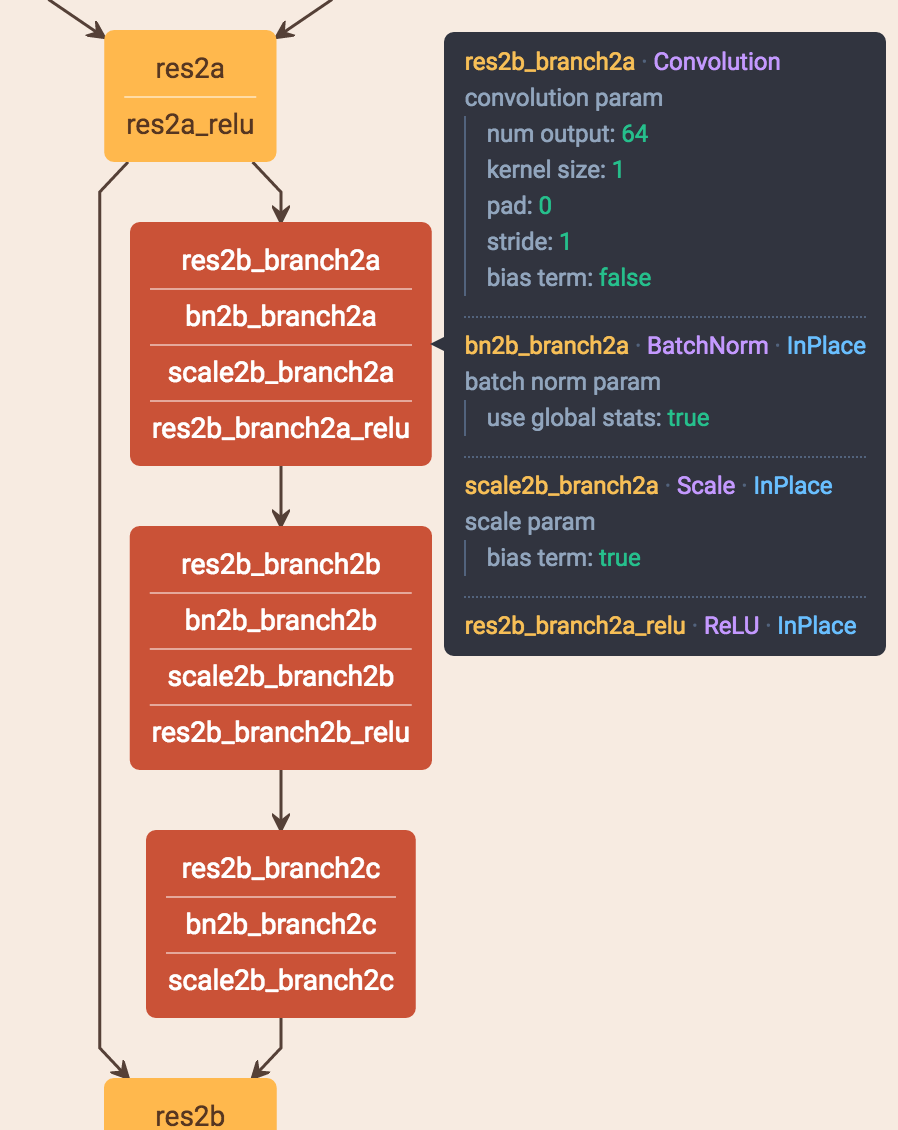

In [8]:
Image(filename='images/decrease_fn.png', width='40%')

#### Increase shape using number of filters
We can also nonlinearly decrease shape from (None, 256, 56, 56) to (None, 128, 28, 28) if we apply simple block with following parameters (look at the first simple block of any risidual block with left branch):
 * num_filters: two times less then parent has
 * filter_size: 1x1
 * stride: 2
 * pad: 0

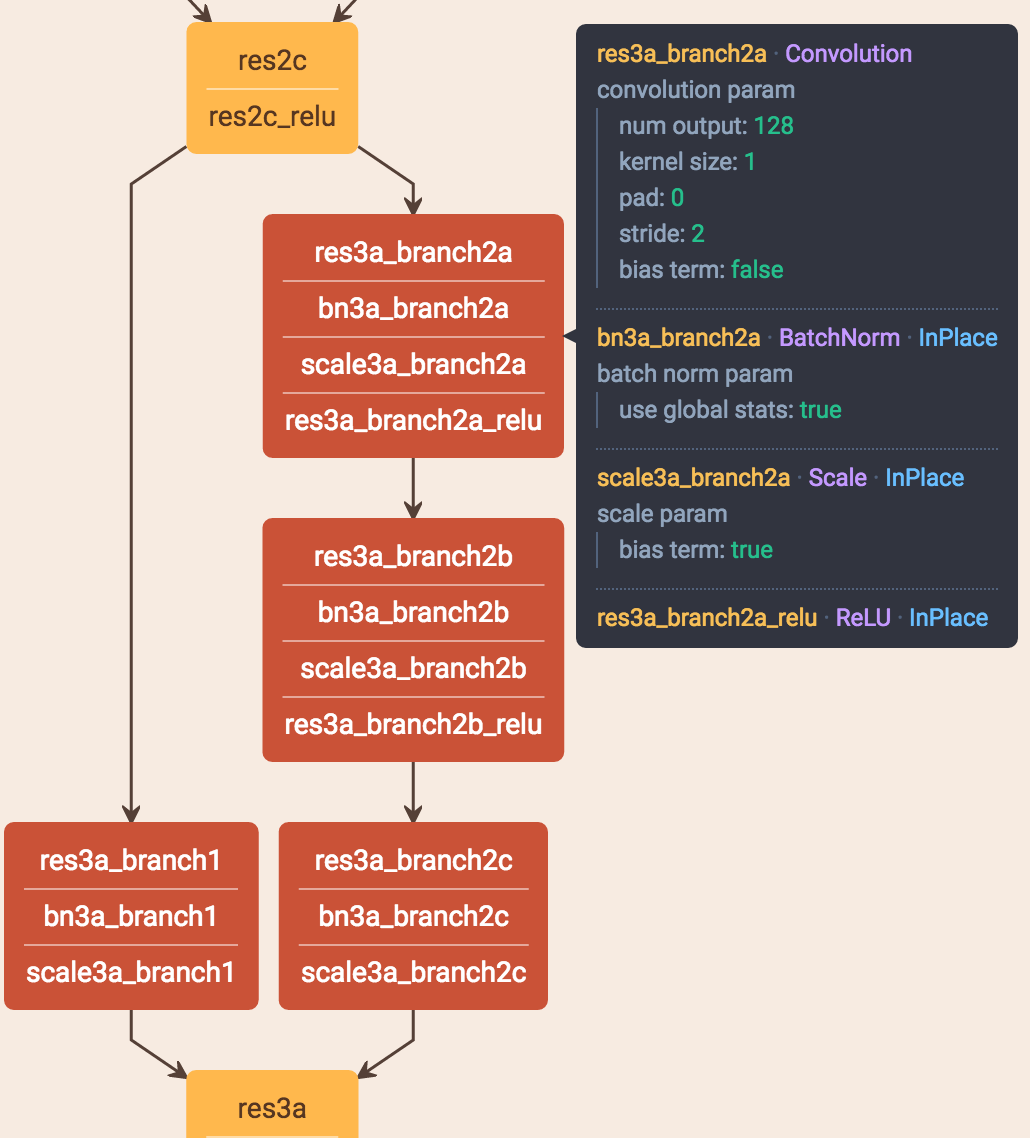

In [9]:
Image(filename='images/decrease_fnstride.png', width='40%')

Following function creates simple block

In [10]:
def build_simple_block(incoming_layer, names,
                       num_filters, filter_size, stride, pad, 
                       use_bias=False, nonlin=rectify):
    """Creates stacked Lasagne layers ConvLayer -> BN -> (ReLu)
    
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    
    names : list of string
        Names of the layers in block
        
    num_filters : int
        Number of filters in convolution layer
        
    filter_size : int
        Size of filters in convolution layer
        
    stride : int
        Stride of convolution layer
        
    pad : int
        Padding of convolution layer
        
    use_bias : bool
        Whether to use bias in conlovution layer
        
    nonlin : function
        Nonlinearity type of Nonlinearity layer
        
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    net = []
    net.append((
            names[0], 
            ConvLayer(incoming_layer, num_filters, filter_size, stride, pad, 
                      flip_filters=False, nonlinearity=None) if use_bias 
            else ConvLayer(incoming_layer, num_filters, filter_size, stride, pad, b=None, 
                           flip_filters=False, nonlinearity=None)
        ))
    
    net.append((
            names[1], 
            BatchNormLayer(net[-1][1])
        ))
    if nonlin is not None:
        net.append((
            names[2], 
            NonlinearityLayer(net[-1][1], nonlinearity=nonlin)
        ))
    
    return dict(net), net[-1][0]

### Residual blocks

ResNet also contains several **residual blockes** built from simple blocks, each of them have two branches; left branch sometimes contains simple block, sometimes not. Each block ends with Elementwise sum layer followed by ReLu nonlinearity.  

http://ethereon.github.io/netscope/#/gist/410e7e48fa1e5a368ee7bca5eb3bf0ca

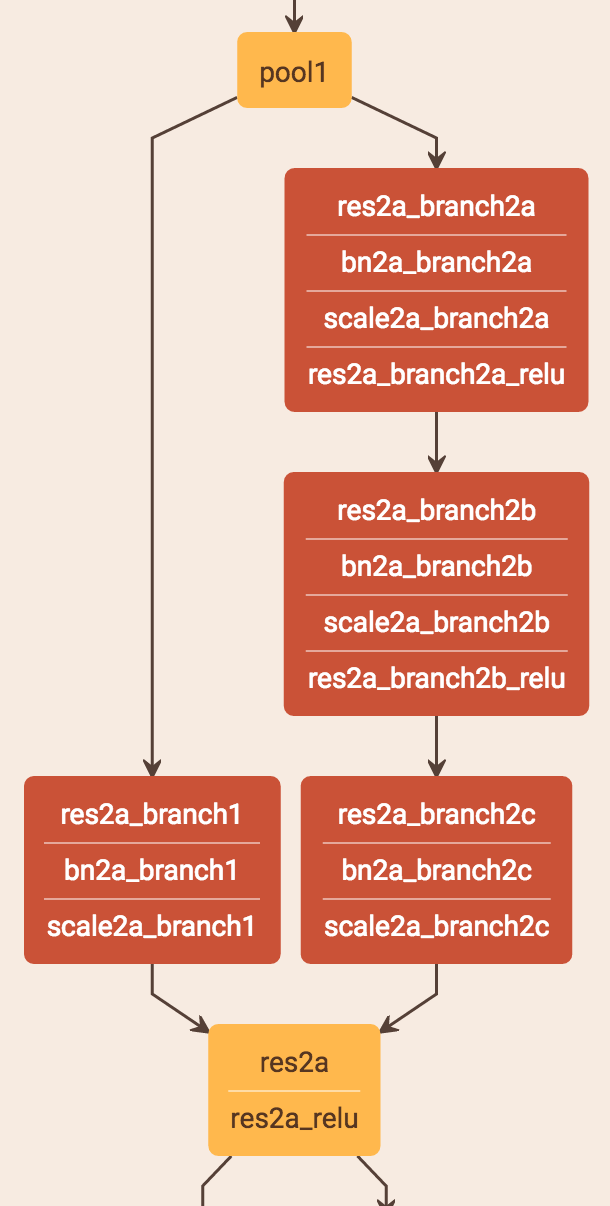

In [11]:
Image(filename='images/left_branch.png', width='40%')

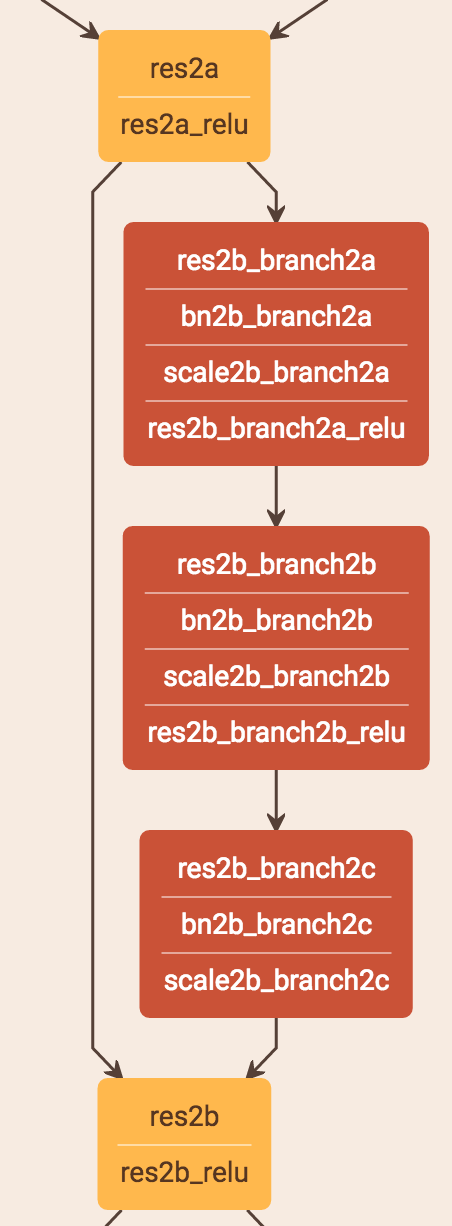

In [12]:
Image(filename='images/no_left_branch.png', width='40%')

In [13]:
simple_block_name_pattern = ['res%s_branch%i%s', 'bn%s_branch%i%s', 'res%s_branch%i%s_relu']

def build_residual_block(incoming_layer, ratio_n_filter=1.0, ratio_size=1.0, has_left_branch=False, 
                         upscale_factor=4, ix=''):
    """Creates two-branch residual block
    
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    
    ratio_n_filter : float
        Scale factor of filter bank at the input of residual block
        
    ratio_size : float
        Scale factor of filter size
        
    has_left_branch : bool
        if True, then left branch contains simple block
        
    upscale_factor : float
        Scale factor of filter bank at the output of residual block
        
    ix : int
        Id of residual block
        
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    net = {}
    
    # right branch
    net_tmp, last_layer_name = build_simple_block(
        incoming_layer, map(lambda s: s % (ix, 2, 'a'), simple_block_name_pattern),
        int(lasagne.layers.get_output_shape(incoming_layer)[1]*ratio_n_filter), 1, int(1.0/ratio_size), 0)
    net.update(net_tmp)
    
    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'b'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1], 3, 1, 1)
    net.update(net_tmp)
    
    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'c'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1]*upscale_factor, 1, 1, 0,
        nonlin=None)
    net.update(net_tmp)
    
    right_tail = net[last_layer_name]
    left_tail = incoming_layer
    
    # left branch
    if has_left_branch:
        net_tmp, last_layer_name = build_simple_block(
            incoming_layer, map(lambda s: s % (ix, 1, ''), simple_block_name_pattern),
            int(lasagne.layers.get_output_shape(incoming_layer)[1]*4*ratio_n_filter), 1, int(1.0/ratio_size), 0,
            nonlin=None)
        net.update(net_tmp)
        left_tail = net[last_layer_name]
        
    net['res%s' % ix] = ElemwiseSumLayer([left_tail, right_tail], coeffs=1)
    net['res%s_relu' % ix] = NonlinearityLayer(net['res%s' % ix], nonlinearity=rectify)
    
    return net, 'res%s_relu' % ix

### Gathering everighting together

Create head of the network (everithing before first residual block)

In [14]:
net = {}
net['input'] = InputLayer((None, 3, 224, 224))
sub_net, parent_layer_name = build_simple_block(
    net['input'], ['conv1', 'bn_conv1', 'conv1_relu'],
    64, 7, 2, 3, use_bias=True)
net.update(sub_net)
net['pool1'] = PoolLayer(net[parent_layer_name], pool_size=3, stride=2, pad=0, mode='max', ignore_border=False)

Create four groups of residual blocks

In [15]:
block_size = list('abc')
parent_layer_name = 'pool1'
for c in block_size:
    if c == 'a':
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1, 1, True, 4, ix='2%s' % c)
    else:
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='2%s' % c)
    net.update(sub_net)
    
block_size = list('abcd')
for c in block_size:
    if c == 'a':
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='3%s' % c)
    else:
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='3%s' % c)
    net.update(sub_net)
    
block_size = list('abcdef')
for c in block_size:
    if c == 'a':
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='4%s' % c)
    else:
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='4%s' % c)
    net.update(sub_net)
    
block_size = list('abc')
for c in block_size:
    if c == 'a':
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='5%s' % c)
    else:
        sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='5%s' % c)
    net.update(sub_net)

Create tail of the network (everighting after last resudual block)

In [16]:
net['pool5'] = PoolLayer(net[parent_layer_name], pool_size=7, stride=1, pad=0, 
                         mode='average_exc_pad', ignore_border=False)
net['fc1000'] = DenseLayer(net['pool5'], num_units=1000, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc1000'], nonlinearity=softmax)

print 'Total number of layers:', len(lasagne.layers.get_all_layers(net['prob']))

Total number of layers: 176


# Transfer weights from caffe to lasagne

## Load pretrained caffe model

In [17]:
net_caffe = caffe.Net('./ResNet-50-deploy.prototxt', './ResNet-50-model.caffemodel', caffe.TEST)
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))
print 'Number of layers: %i' % len(layers_caffe.keys())

Number of layers: 245


## Copy weights

There is one more issue with BN layer: caffa stores variance $\sigma^2$, but lasagne stores inverted standard deviation $\dfrac{1}{\sigma}$, so we need make simple transfommation to handle it.

Other issue reffers to weights ofthe dense layer, in caffe it is transposed, we should handle it too.

In [18]:
for name, layer in net.items():    
    if name not in layers_caffe:
        print name, type(layer).__name__
        continue
    if isinstance(layer, BatchNormLayer):
        layer_bn_caffe = layers_caffe[name]
        layer_scale_caffe = layers_caffe['scale' + name[2:]]
        layer.gamma.set_value(layer_scale_caffe.blobs[0].data)
        layer.beta.set_value(layer_scale_caffe.blobs[1].data)
        layer.mean.set_value(layer_bn_caffe.blobs[0].data)
        layer.inv_std.set_value(1/np.sqrt(layer_bn_caffe.blobs[1].data) + 1e-4)
        continue
    if isinstance(layer, DenseLayer):
        layer.W.set_value(layers_caffe[name].blobs[0].data.T)
        layer.b.set_value(layers_caffe[name].blobs[1].data)
        continue
    if len(layers_caffe[name].blobs) > 0:
        layer.W.set_value(layers_caffe[name].blobs[0].data)
    if len(layers_caffe[name].blobs) > 1:
        layer.b.set_value(layers_caffe[name].blobs[1].data)

# Testing

Read ImageNet synset

In [19]:
with open('./imagenet_classes.txt', 'r') as f:
    classes = map(lambda s: s.strip(), f.readlines())

Download some image urls for recognition

In [20]:
index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')
np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:100]

Load mean values

In [21]:
blob = caffe.proto.caffe_pb2.BlobProto()
data = open('./ResNet_mean.binaryproto', 'rb').read()
blob.ParseFromString(data)
mean_values = np.array(caffe.io.blobproto_to_array(blob))[0]

Image loader

In [22]:
def prep_image(url, fname=None):
    if fname is None:
        ext = url.split('.')[-1]
        im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    else:
        ext = fname.split('.')[-1]
        im = plt.imread(fname, ext)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    rawim = np.copy(im).astype('uint8')
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    im = im[::-1, :, :]
    im = im - mean_values
    return rawim, floatX(im[np.newaxis])

Lets take five images and compare prediction of Lasagne with Caffe

http://farm1.static.flickr.com/8/11912062_a1dda4fa83.jpg
Lasagne:
   German shepherd, German shepherd dog, German police dog, alsatian 0.774086
   malinois 0.186879
   Norwegian elkhound, elkhound 0.0328459
   Border terrier 0.0018078
   Leonberg 0.00108889
Caffe:
   German shepherd, German shepherd dog, German police dog, alsatian 0.763986
   malinois 0.198122
   Norwegian elkhound, elkhound 0.0311307
   Border terrier 0.0020401
   Leonberg 0.00111081


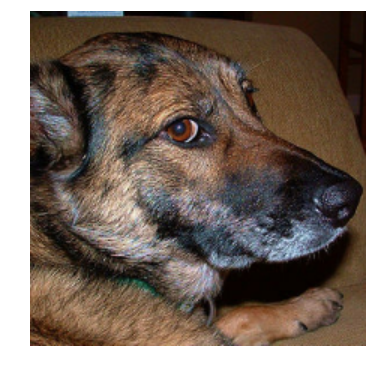




http://farm4.static.flickr.com/3649/3320711239_0663522aca.jpg
Lasagne:
   shovel 0.999916
   barrow, garden cart, lawn cart, wheelbarrow 8.14444e-05
   paddle, boat paddle 1.36612e-06
   spatula 4.59891e-07
   lawn mower, mower 1.6695e-07
Caffe:
   shovel 0.999916
   barrow, garden cart, lawn cart, wheelbarrow 8.15481e-05
   paddle, boat paddle 1.3575e-06
   spatula 4.28181e-07
   lawn mower, mower 1.75126e-07


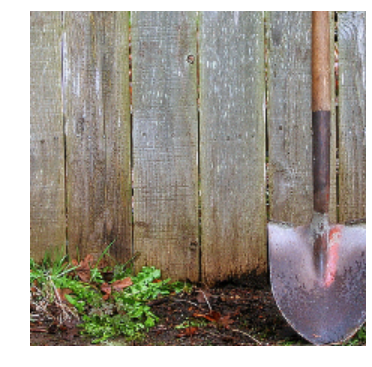




http://farm4.static.flickr.com/3057/2975067450_98bec812af.jpg
Lasagne:
   wild boar, boar, Sus scrofa 0.907356
   hog, pig, grunter, squealer, Sus scrofa 0.0918346
   warthog 0.000802735
   African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus 2.60022e-06
   hyena, hyaena 1.75227e-06
Caffe:
   wild boar, boar, Sus scrofa 0.90471
   hog, pig, grunter, squealer, Sus scrofa 0.0944353
   warthog 0.000848829
   African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus 2.4859e-06
   hyena, hyaena 1.70266e-06


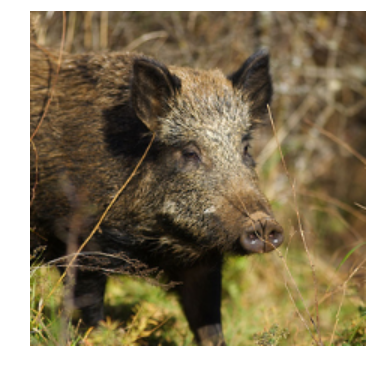




http://farm3.static.flickr.com/2452/3932323110_833174f459.jpg
Lasagne:
   necklace 0.463087
   bottlecap 0.144957
   altar 0.0602399
   hair slide 0.0504839
   clog, geta, patten, sabot 0.0430784
Caffe:
   necklace 0.453895
   bottlecap 0.150969
   altar 0.05851
   hair slide 0.0483679
   clog, geta, patten, sabot 0.0413533


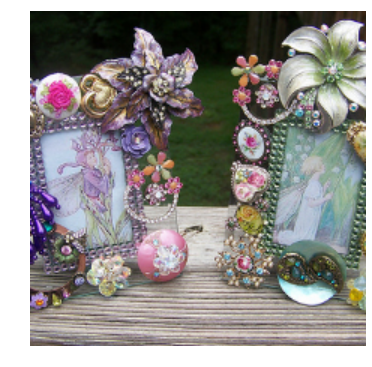




http://www.tmk.com/tiger/6F5S5684-l.jpg
Failed to download
http://farm6.static.flickr.com/5267/5669396982_0558c7610f.jpg
Failed to download
http://farm4.static.flickr.com/3156/2683541317_be7ec2c07c.jpg
Lasagne:
   steel arch bridge 0.999592
   pier 0.000390676
   suspension bridge 1.13881e-05
   paddlewheel, paddle wheel 4.84823e-06
   viaduct 4.86115e-07
Caffe:
   steel arch bridge 0.999587
   pier 0.000394414
   suspension bridge 1.11275e-05
   paddlewheel, paddle wheel 5.68047e-06
   viaduct 5.07271e-07


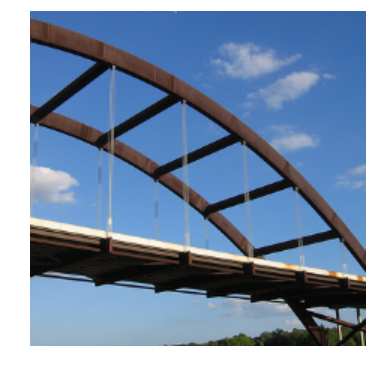

In [23]:
n = 5
m = 5
i = 0
for url in image_urls:
    print url
    try:
        rawim, im = prep_image(url)
    except:
        print 'Failed to download'
        continue

    prob_lasangne = np.array(lasagne.layers.get_output(net['prob'], im, deterministic=True).eval())[0]
    prob_caffe = net_caffe.forward_all(data=im)['prob'][0]

    
    print 'Lasagne:'
    res = sorted(zip(classes, prob_lasangne), key=lambda t: t[1], reverse=True)[:n]
    for c, p in res:
        print '  ', c, p
        
    print 'Caffe:'
    res = sorted(zip(classes, prob_caffe), key=lambda t: t[1], reverse=True)[:n]
    for c, p in res:
        print '  ', c, p
    
    plt.figure()
    plt.imshow(rawim.astype('uint8'))
    plt.axis('off')
    plt.show()
    
    i += 1
    if i == m:
        break
    
    print '\n\n'

In [24]:
model = {
    'values': lasagne.layers.get_all_param_values(net['prob']),
    'synset_words': classes,
    'mean_image': mean_values
}

pickle.dump(model, open('./resnet50.pkl', 'wb'), protocol=-1)